In [105]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import re
import matplotlib.pyplot as plt
from autoexperiment.template import generate_job_defs

In [106]:
def pretty(i):
    if i > 10 ** 9:
        return f"{i/10**9:.2f}B"
    if i < 10**9 and i > 10**6:
        return f"{i/10**6:.2f}M"
    else:
        return i

In [107]:
jobs = generate_job_defs("config.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    for path in paths:
        if "latest" in path:
            continue
        samples_seen = int(job.params['train_num_samples']) * int(job.params['epochs'])
        data = json.load(open(path))
        dic = {
            'model': job.params['model'],
            'samples_seen': samples_seen,
            'samples_seen_pretty': pretty(samples_seen),
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
            "total_epochs": int(job.params["epochs"]),
        }
        dic.update(data['metrics'])
        results.append(dic)
results = pd.DataFrame(results)
results.head()

,model,samples_seen,samples_seen_pretty,pretrain_dataset,downstream_dataset,epoch,total_epochs,image_retrieval_recall@5,text_retrieval_recall@5,acc1,acc5,mean_per_class_recall
0,ViT-S-32,128000000,128.00M,datacomp,wds/mscoco_captions,1,1,0.082474,0.1210,NaN,NaN,NaN
1,ViT-S-32,128000000,128.00M,datacomp,wds/imagenet1k,1,1,NaN,NaN,0.08320,0.21856,0.08328
2,ViT-S-32,1280000000,1.28B,datacomp,wds/imagenet1k,6,10,NaN,NaN,0.42782,0.69976,0.42790
3,ViT-S-32,1280000000,1.28B,datacomp,wds/imagenet1k,4,10,NaN,NaN,0.37134,0.64196,0.37144
4,ViT-S-32,1280000000,1.28B,datacomp,wds/mscoco_captions,1,10,0.082394,0.1276,NaN,NaN,NaN


# Leaderboard

In [110]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/imagenet1k'
metric = 'acc1'

#ds = 'wds/mscoco_captions'
#metric = 'image_retrieval_recall@5'
d = d[d.downstream_dataset==ds]
d[['model', 'samples_seen_pretty', 'downstream_dataset', metric]].sort_values(by=metric, ascending=False).round(2)

,model,samples_seen_pretty,downstream_dataset,acc1
283,ViT-M-32,12.80B,wds/imagenet1k,0.62
135,ViT-S-32,12.80B,wds/imagenet1k,0.58
242,ViT-M-32,1.28B,wds/imagenet1k,0.54
9,ViT-S-32,1.28B,wds/imagenet1k,0.48
222,ViT-M-32,128.00M,wds/imagenet1k,0.10
1,ViT-S-32,128.00M,wds/imagenet1k,0.08


# Results of a specifc model on a downstream task

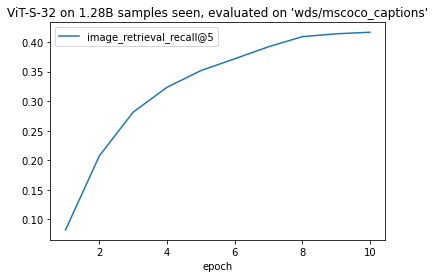

    epoch  image_retrieval_recall@5
4       1                      0.08
7       2                      0.21
18      3                      0.28
20      4                      0.32
8       5                      0.35
10      6                      0.37
16      7                      0.39
5       8                      0.41
12      9                      0.41
19     10                      0.42


In [109]:
d =results

model = "ViT-S-32"
#samples_seen = "12.80B"
samples_seen = "1.28B"

#ds = 'wds/imagenet1k'
#metric = 'acc1'
ds = "wds/mscoco_captions"
metric = 'image_retrieval_recall@5'

d = d[(d.model == model) & (d.samples_seen_pretty==samples_seen) & (d.downstream_dataset==ds)]
d = d.sort_values(by='epoch')
d.plot(x='epoch', y=metric)
plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
plt.show()
print(d[['epoch', metric]].round(2))